In [1]:
import os
import torch
import data
import utils
from scipy.interpolate import interp1d
import config as cfg
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
from copy import deepcopy
from xpbd_softbody_layer import XPBDStep
import pyvista as pv
import matplotlib.pyplot as plt
from xpbd_softbody import XPBDSoftbody

In [2]:
def get_energy_boundary(softbody: XPBDSoftbody,
                         V_predict: torch.Tensor,
                         V_boundary_stiffness: torch.Tensor,
                         mask: set = None) -> torch.Tensor:
    
    V_boundary_stiffness_threshold = V_boundary_stiffness.clone()
    V_boundary_stiffness_threshold[V_boundary_stiffness_threshold < 1e-3] = 0

    dist_C, dist_C_stiffness = __get_spring_boundary_constraints(softbody,
                                                      V_predict,
                                                      V_boundary_stiffness_threshold,
                                                      mask)
    # energy is C^2 * stiffness / 2
    boundary_energy = torch.square(dist_C) * dist_C_stiffness / 2
    return boundary_energy

def __get_spring_boundary_constraints(softbody, V_predict, V_boundary_stiffness, mask=None):
    C = []
    C_stiffness = []
    # collect all distance constraints
    for C_dist, C_init_d in zip(softbody.C_boundary_list, softbody.C_init_boundary_d_list):
        if mask == None or (C_dist[:, 0] in mask and C_dist[:, 1] in mask):
            # position difference vectors
            N = V_predict[C_dist[:, 0]] - V_predict[C_dist[:, 1]]
            # distance
            D = torch.norm(N, p=2, dim=1, keepdim=True)
            # constarint values
            C.append(D - C_init_d)
            # average stiffness
            C_stiffness.append(V_boundary_stiffness[C_dist[:, 0]])
    return torch.cat(C), torch.cat(C_stiffness)

In [3]:
mesh, softbody = data.get_xpbd_grape()
print(mesh.points.shape)

torch.Size([600, 3])
torch.Size([1200, 3])
(600, 3)


In [4]:
np.max(softbody.T_list[0])

599

In [5]:
# Hardcoded control trajectory
control_trajectory = np.array([[0.000224, 0.010794, -0.001233],
                               [0.000186, 0.008863, 0.002481],
                               [0.000208, 0.00664, 0.003521],
                               [0.000197, 0.004594, 0.004361],
                               [0.000208, 0.002349, 0.005903],
                               [0.000197, -0.00004, 0.006602],
                               [0.000208, -0.00204, 0.007502],
                               [0.000208, -0.00404, 0.008502]])

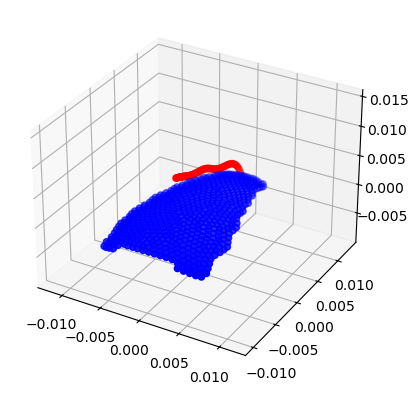

In [6]:
# interpolate trajectory
x = np.arange(control_trajectory.shape[0])
xnew = np.linspace(x.min(), x.max(), control_trajectory.shape[0]*10)  # 10 times denser
f = interp1d(x, control_trajectory, axis=0, kind='cubic')
control_trajectory = f(xnew)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(control_trajectory[:, 0], control_trajectory[:, 1], control_trajectory[:, 2], c='r', marker='o')
ax.scatter(mesh.points[:, 0], mesh.points[:, 1], mesh.points[:, 2], c='b', marker='o')
utils.axisEqual3D(ax)
plt.show()

In [7]:
control_trajectory = torch.from_numpy(control_trajectory).to(cfg.device)
softbody.init_grasp_constraints(loc=deepcopy(control_trajectory[0]), radius=1e-3)


cloth_dist_stiffness = 1
V_boundary_stiffness = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * V_boundary_stiffness

control point connects to 8 vertices


In [8]:
pv.set_plot_theme('document')
pl = pv.Plotter()

# skin being peeled
pl.add_mesh(mesh, color='#9f5547ff', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface')

# ellipsoid grape
grape = pv.read('assets/grape.ply')
grape.points = grape.points - np.array([0, 0, 1e-4])
pl.add_mesh(grape, color='#9f5547ff', show_edges=False, lighting=False,style='surface')

# grape meat that is green
grape_meat= pv.read('assets/grape_skin.ply')
grape_meat.points = grape_meat.points - np.array([0, 0, 2e-4])
pl.add_mesh(grape_meat, color='#c0ab5eff', show_edges=False, lighting=False,style='surface')

Actor (0x7f13b1966560)
  Center:                     (-9.851530194282532e-06, 0.0014494163915514946, -0.0009795548299327494)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    -6.636E-03, 6.616E-03
  Y Bounds                    -1.040E-02, 1.330E-02
  Z Bounds                    -3.189E-03, 1.230E-03
  User matrix:                Set
  Has mapper:                 True

Property (0x7f13b1966980)
  Ambient:                     0.0
  Ambient color:               Color(hex='#c0ab5eff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(hex='#c0ab5eff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(hex='#c0ab5eff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
 

In [9]:
test = softbody.C_boundary_list[0].cpu().numpy()

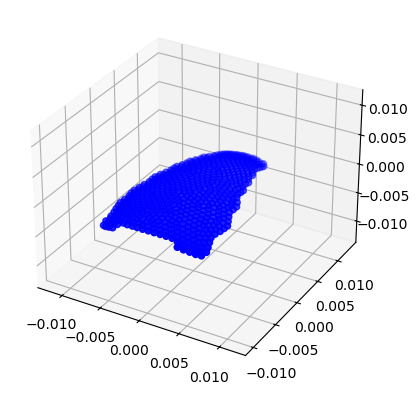

In [10]:
ax = plt.figure().add_subplot(projection='3d')
# ax.scatter(control_trajectory[:, 0], control_trajectory[:, 1], control_trajectory[:, 2], c='r', marker='o')
ax.scatter(mesh.points[test[:, 0], 0], mesh.points[test[:, 0], 1], mesh.points[test[:, 0], 2], c='b', marker='o')
utils.axisEqual3D(ax)
plt.show()

In [11]:
with torch.no_grad():
    for t in range(1, control_trajectory.shape[0]):
        softbody.grasp_point = control_trajectory[t].clone()

        step_ref = XPBDStep(softbody,
                        V_dist_stiffness=V_dist_stiffness, 
                        V_shape_stiffness=None,
                        V_boundary_stiffness=V_boundary_stiffness, 
                        dt=cfg.dt,
                        substep=cfg.substep,
                        iteration=cfg.iteration,
                        quasi_static=cfg.quasi_static,
                        plane_height=cfg.ground_plane_height, 
                        use_shape_matching=cfg.use_shape_matching,
                        use_spring_boundary=cfg.use_spring_boundary) #cfg.use_spring_boundary
        V_ref, V_velocity_ref = step_ref.forward(
            softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()

        energy = get_energy_boundary(softbody, softbody.V, V_boundary_stiffness)
        
        V_boundary_stiffness[:cfg.n_surf][energy.squeeze() > 1e-8] = 1e-5
        # print('bound energy', V_boundary_stiffness.cpu().numpy().T)

        mesh.points = softbody.V.cpu().numpy()
        print(mesh.points[0], mesh.points[600])
        # pl.show(interactive_update=True)

[-0.00020184  0.00020229  0.00137441] [-0.00020112  0.00020722  0.00139302]
[-0.00020191  0.00020167  0.00137383] [-0.00020112  0.00020722  0.00139302]
[-0.00020205  0.0002017   0.0013738 ] [-0.00020112  0.00020722  0.00139302]
[-0.00020213  0.00020197  0.00137373] [-0.00020112  0.00020722  0.00139302]
[-0.0002023   0.00020212  0.0013737 ] [-0.00020112  0.00020722  0.00139302]
[-0.00020233  0.00020196  0.00137374] [-0.00020112  0.00020722  0.00139302]
[-0.00020233  0.0002016   0.00137384] [-0.00020112  0.00020722  0.00139302]
[-0.00020229  0.00020069  0.00137414] [-0.00020112  0.00020722  0.00139302]
[-0.00020166  0.0002006   0.00137415] [-0.00020112  0.00020722  0.00139302]
[-0.00020153  0.00020056  0.00137416] [-0.00020112  0.00020722  0.00139302]
[-0.00020126  0.00020064  0.00137412] [-0.00020112  0.00020722  0.00139302]
[-0.00020107  0.00020152  0.00137383] [-0.00020112  0.00020722  0.00139302]
[-0.00020133  0.00020257  0.00137353] [-0.00020112  0.00020722  0.00139302]
[-0.00020142

In [12]:
test = V_boundary_stiffness.cpu().numpy()
pcd = np.argwhere(test == 1e-5)

In [13]:
pcd = mesh.points[pcd[:, 0]]

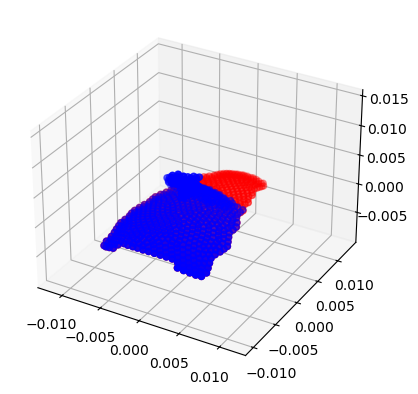

In [14]:
ax = plt.figure().add_subplot(projection='3d')
# ax.scatter(control_trajectory[:, 0], control_trajectory[:, 1], control_trajectory[:, 2], c='r', marker='o')
ax.scatter(mesh.points[:600, 0], mesh.points[:600, 1], mesh.points[:600, 2], c='b', marker='o')
ax.scatter(mesh.points[600:, 0], mesh.points[600:, 1], mesh.points[600:, 2], c='r', marker='o')
utils.axisEqual3D(ax)
plt.show()